# 영화평 Text 분류 - Sentiment Analysis

- IMDB (Internet Movie Database, https://www.imdb.com/)  Dataset


- 각 25,000 개의 training/testing set 으로 구성된 IMDB 영화관람평  


- “imdb_reviews” – encoding 되어있지 않은 string 형태의 data  


- label : positive, negative binary classification

## imdb_reviews (string data) 이용

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# with_info = True -> 어떤 데이터셋인지 정보도 함께 가져옴
# as_supervised = True -> 지도학습용으로 쓰겠다
dataset, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteO9JMYR/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteO9JMYR/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteO9JMYR/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_dataset, test_dataset = dataset['train'], dataset['test']
len(train_dataset), len(test_dataset)

(25000, 25000)

In [5]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### tfds 는 tf.Tensor 반환

In [7]:
for input, label in train_dataset:
    print(label)
    print(input)
    break

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)


In [8]:
for input, label in dataset['test']:
    print(label)
    print(input)
    break

tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), 

## keras.preprocessing module 을 이용하여 tokenize 및 padding
- keras.preprocessing.text.Tokenizer  

- keras.preprocessing.sequence.pad_sequence

In [11]:
train_sentences = []
train_labels = []
test_sentences = []
test_labels = []

for sent, label in train_dataset:
    train_sentences.append(str(sent.numpy())) # 문장 -> string 형식 변환 후 numpy()로 변환
    train_labels.append(label.numpy()) # 긍정 0 부정 1 -> numpy()로 변환

for sent, label in test_dataset:
    test_sentences.append(str(sent.numpy())) # 문장 -> string 형식 변환 후 numpy()로 변환
    test_labels.append(label.numpy()) # 긍정 0 부정 1 -> numpy()로 변환

In [12]:
len(train_sentences), len(train_labels), len(test_sentences), len(test_labels)

(25000, 25000, 25000, 25000)

In [15]:
print(train_labels[-1])
print(train_sentences[-1])
print(test_labels[-1])
print(test_sentences[-1])

1
b'First of all, Riget is wonderful. Good comedy and mystery thriller at the same time. Nice combination of strange \'dogma\' style of telling the story together with good music and great actors. But unfortunately there\'s no \'the end\'. As for me it\'s unacceptable. I was thinking... how it will be possible to continue the story without Helmer and Drusse? ...and I have some idea. I think Lars should make RIGET III a little bit different. I\'m sure that 3rd part without Helmer wouldn\'t be the same. So here\'s my suggestion. Mayble little bit stupid, maybe not. I know that Lars likes to experiment. So why not to make small experiment with Riget3? I think the only solution here is to create puppet-driven animation (like for example "team America" by Trey Parker) or even computer 3d animation. I know it\'s not the same as real actors, but in principle I believe it could work... only this way it\'s possible to make actors alive again. For Riget fans this shouldn\'t be so big difference 

## train_labels, test_labels  list를 numpy array 로 변환

- 위 값들은 파이썬에서 사용하기 위해 numpy.array() 형태로 바꿔야 함

In [16]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
train_labels.shape, test_labels.shape

((25000,), (25000,))

## train_sentences, test_sentences text 를 sequence 로 변환
- 문장들을 토큰 단위로 잘라준다.
- tokenizer -> texts_to_sequences 진행

In [17]:
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token = '<OOV>')
tokenizer.fit_on_texts(train_sentences)

In [ ]:
tokenizer.index_word

In [24]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

print(train_sequences[0])
print(test_sequences[0])

[59, 12, 14, 35, 439, 400, 18, 174, 29, 1, 9, 33, 1378, 3401, 42, 496, 1, 197, 25, 88, 156, 19, 12, 211, 340, 29, 70, 248, 213, 9, 486, 62, 70, 88, 116, 99, 24, 5740, 12, 3317, 657, 777, 12, 18, 7, 35, 406, 8228, 178, 2477, 426, 2, 92, 1253, 140, 72, 149, 55, 2, 1, 7525, 72, 229, 70, 2962, 16, 1, 2880, 1, 1, 1506, 4998, 3, 40, 3947, 119, 1608, 17, 3401, 14, 163, 19, 4, 1253, 927, 7986, 9, 4, 18, 13, 14, 4200, 5, 102, 148, 1237, 11, 240, 692, 13, 44, 25, 101, 39, 12, 7232, 1, 39, 1378, 1, 52, 409, 11, 99, 1214, 874, 145, 10]
[59, 44, 25, 109, 13, 97, 4115, 16, 742, 4370, 10, 14, 316, 5, 2, 593, 354, 16, 1864, 1212, 1, 16, 680, 7499, 5595, 1, 773, 6, 13, 1037, 1, 1, 439, 491, 1, 4, 1, 334, 3610, 20, 229, 3, 15, 5796, 3, 15, 1646, 15, 102, 5, 2, 3597, 101, 11, 1450, 1528, 12, 251, 235, 11, 216, 2, 377, 6429, 3, 62, 95, 11, 174, 105, 11, 1528, 180, 12, 251, 37, 6, 1144, 1, 682, 7, 4452, 1, 4, 1, 334, 7, 37, 8367, 377, 5, 1420, 1, 13, 30, 64, 28, 6, 874, 181, 17, 4, 1050, 5, 12, 224, 3, 83,

# 전체 길이를 같은 길이로 맞춰주는 작업 진행
- Python의 List comprehension 사용

In [26]:
[len(s) for s in train_sequences] + [len(s) for s in test_sequences]

[118,
 113,
 133,
 90,
 82,
 290,
 612,
 119,
 233,
 132,
 177,
 283,
 552,
 150,
 344,
 89,
 336,
 464,
 276,
 344,
 197,
 290,
 265,
 119,
 201,
 131,
 183,
 163,
 163,
 151,
 239,
 529,
 228,
 113,
 83,
 223,
 122,
 194,
 108,
 130,
 131,
 481,
 475,
 97,
 147,
 108,
 171,
 491,
 201,
 292,
 73,
 241,
 40,
 250,
 140,
 136,
 298,
 731,
 213,
 160,
 162,
 264,
 242,
 161,
 291,
 128,
 281,
 108,
 181,
 425,
 262,
 76,
 119,
 51,
 171,
 125,
 377,
 132,
 172,
 171,
 133,
 94,
 779,
 143,
 195,
 260,
 69,
 274,
 192,
 138,
 163,
 559,
 76,
 59,
 881,
 123,
 70,
 164,
 151,
 134,
 153,
 430,
 285,
 265,
 154,
 122,
 124,
 321,
 742,
 128,
 131,
 118,
 69,
 61,
 121,
 62,
 212,
 485,
 120,
 147,
 483,
 57,
 449,
 292,
 135,
 126,
 90,
 365,
 122,
 145,
 120,
 132,
 335,
 178,
 80,
 247,
 510,
 463,
 53,
 53,
 634,
 149,
 161,
 163,
 426,
 145,
 144,
 93,
 152,
 381,
 198,
 105,
 324,
 261,
 126,
 171,
 559,
 132,
 241,
 383,
 199,
 105,
 111,
 43,
 197,
 148,
 219,
 116,
 37,
 295,
 169,

In [27]:
max([len(s) for s in train_sequences] + [len(s) for s in test_sequences])

2527

In [28]:
min([len(s) for s in train_sequences] + [len(s) for s in test_sequences])

7

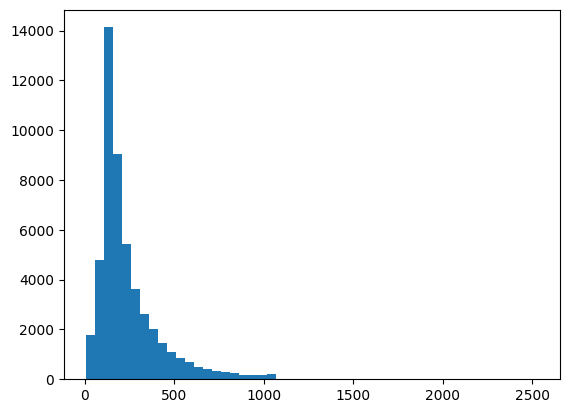

In [31]:
plt.hist([len(s) for s in train_sequences] + [len(s) for s in test_sequences], bins=50)
plt.show()

In [36]:
# truncating = 'post' -> max_length 길이를 넘을 시 앞 부분을 자름, 'pre' -> 뒷 부분 자름
max_length = 150

train_padded = pad_sequences(train_sequences, maxlen = max_length, truncating = 'post', padding = 'post')
test_padded = pad_sequences(test_sequences, maxlen = max_length, truncating = 'post', padding = 'post')

In [37]:
print(train_padded.shape)
print(test_padded.shape)
print(train_padded[0])
print(test_padded[0])

(25000, 150)
(25000, 150)
[  59   12   14   35  439  400   18  174   29    1    9   33 1378 3401
   42  496    1  197   25   88  156   19   12  211  340   29   70  248
  213    9  486   62   70   88  116   99   24 5740   12 3317  657  777
   12   18    7   35  406 8228  178 2477  426    2   92 1253  140   72
  149   55    2    1 7525   72  229   70 2962   16    1 2880    1    1
 1506 4998    3   40 3947  119 1608   17 3401   14  163   19    4 1253
  927 7986    9    4   18   13   14 4200    5  102  148 1237   11  240
  692   13   44   25  101   39   12 7232    1   39 1378    1   52  409
   11   99 1214  874  145   10    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[  59   44   25  109   13   97 4115   16  742 4370   10   14  316    5
    2  593  354   16 1864 1212    1   16  680 7499 5595    1  773    6
   13 1037    1    1  439  491    1    4    1  334 3610   20  229    3

- sequence data 를 sentence 로 reverse conversion

In [42]:
# tokenizer.index_word.get(i, '<pad>') -> index_word에서 값을 가져옴, not found 시 '<pad'>로 변환
def decode_review(sequence):
    return ' '.join([tokenizer.index_word.get(i, '<pad>') for i in sequence])

print(decode_review(train_padded[0]))
print()
print(train_sentences[0])

b this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining <OOV> like christopher <OOV> good name i could barely sit through it <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but 

## model define

In [46]:
# vocab_size + 1 = pad가 추가되서 +1 해준다.
model = Sequential()
model.add(Embedding(vocab_size+1, 64))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          640064    
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 714433 (2.73 MB)
Trainable params: 714433 (2.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### loss와 val_loss는 같이 줄고, acc와 val_acc는 같이 증가해야 훈련이 잘 되는건데,        
### Language 모델에서는 데이터셋이 작기 때문에 Overfitting이 나오는 현상을 감안해야한다.

In [48]:
history = model.fit(train_padded, train_labels,
                    epochs=30, batch_size=128,
                    validation_data=(test_padded, test_labels),
                    verbose=1)

Epoch 1/30
196/196 [==============================] - 53s 218ms/step - loss: 0.4462 - accuracy: 0.7783 - val_loss: 0.3755 - val_accuracy: 0.8344
Epoch 2/30
196/196 [==============================] - 20s 104ms/step - loss: 0.2612 - accuracy: 0.8968 - val_loss: 0.3779 - val_accuracy: 0.8332
Epoch 3/30
196/196 [==============================] - 14s 74ms/step - loss: 0.2112 - accuracy: 0.9196 - val_loss: 0.4289 - val_accuracy: 0.8312
Epoch 4/30
196/196 [==============================] - 10s 53ms/step - loss: 0.1679 - accuracy: 0.9379 - val_loss: 0.5596 - val_accuracy: 0.8144
Epoch 5/30
196/196 [==============================] - 9s 46ms/step - loss: 0.1351 - accuracy: 0.9520 - val_loss: 0.7257 - val_accuracy: 0.8148
Epoch 6/30
196/196 [==============================] - 9s 47ms/step - loss: 0.1210 - accuracy: 0.9552 - val_loss: 0.6499 - val_accuracy: 0.8188
Epoch 7/30
196/196 [==============================] - 8s 40ms/step - loss: 0.1077 - accuracy: 0.9609 - val_loss: 0.7247 - val_accuracy: 

In [ ]:
# model = Sequential([
#     Embedding(vocab_size+1, 64),
#     Bidirectional(tf.keras.layers.LSTM(64)),
#     Dense(64, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640064    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 714,433
Trainable params: 714,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# %%time
# num_epochs = 30
# history = model.fit(train_padded, train_labels, epochs=num_epochs, batch_size=128,
#                 validation_data=(test_padded, test_labels), verbose=1)

Epoch 1/30
196/196 [==============================] - 11s 34ms/step - loss: 0.4854 - accuracy: 0.7524 - val_loss: 0.3791 - val_accuracy: 0.8358
Epoch 2/30
196/196 [==============================] - 6s 29ms/step - loss: 0.2780 - accuracy: 0.8899 - val_loss: 0.3847 - val_accuracy: 0.8384
Epoch 3/30
196/196 [==============================] - 6s 29ms/step - loss: 0.2085 - accuracy: 0.9224 - val_loss: 0.3983 - val_accuracy: 0.8287
Epoch 4/30
196/196 [==============================] - 6s 29ms/step - loss: 0.1630 - accuracy: 0.9403 - val_loss: 0.4758 - val_accuracy: 0.8135
Epoch 5/30
196/196 [==============================] - 6s 29ms/step - loss: 0.1347 - accuracy: 0.9518 - val_loss: 0.4993 - val_accuracy: 0.8180
Epoch 6/30
196/196 [==============================] - 6s 29ms/step - loss: 0.1032 - accuracy: 0.9640 - val_loss: 0.5570 - val_accuracy: 0.8024
Epoch 7/30
196/196 [==============================] - 6s 29ms/step - loss: 0.0779 - accuracy: 0.9734 - val_loss: 0.7996 - val_accuracy: 0.813

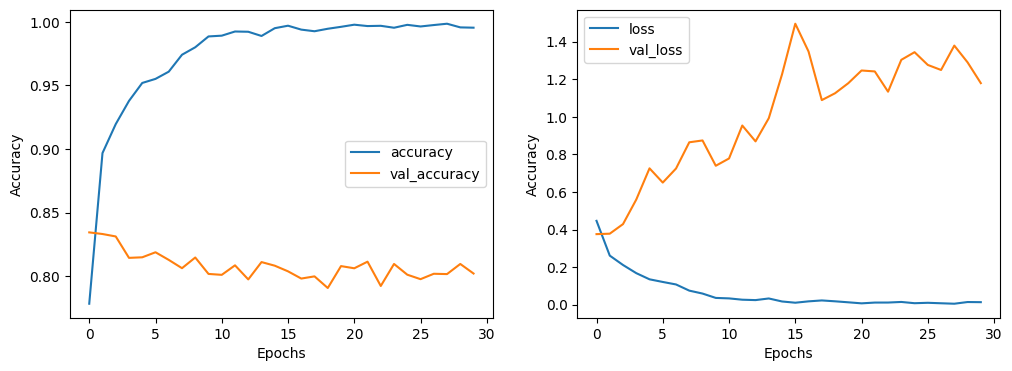

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label = 'accuracy')
ax1.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label = 'loss')
ax2.plot(history.history['val_loss'], label = 'val_loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [60]:
sample_text = ['The movie was terrible. I would not recommend the movie']
sample_text2 = ['The movie was fantastic. I would recommend the movie']
sample_text3 = ['The animation and graphics were out of this world']

sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_seq2 = tokenizer.texts_to_sequences(sample_text2)
sample_seq3 = tokenizer.texts_to_sequences(sample_text3)
print(sample_seq)

sample_padded = pad_sequences(sample_seq, maxlen=max_length, padding='post', truncating='post')
sample_padded2 = pad_sequences(sample_seq2, maxlen=max_length, padding='post', truncating='post')
sample_padded3 = pad_sequences(sample_seq3, maxlen=max_length, padding='post', truncating='post')
print(sample_padded)

[[2, 18, 14, 400, 11, 64, 24, 392, 2, 18]]
[[  2  18  14 400  11  64  24 392   2  18   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]]


In [63]:
print(model.predict(sample_padded))
print(model.predict(sample_padded2))
print(model.predict(sample_padded3))

1/1 [==============================] - 0s 25ms/step
[[0.34532636]]
1/1 [==============================] - 0s 22ms/step
[[0.9816113]]
1/1 [==============================] - 0s 24ms/step
[[0.98778665]]


In [86]:
score = float(model.predict(sample_padded))
score

1/1 [==============================] - 0s 23ms/step


0.34532636404037476

In [87]:
if score > 0.5:
    print("{:.2f}% 확률로 긍정 리뷰".format(score * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰".format((1 - score) * 100))

65.47% 확률로 부정 리뷰


In [80]:
score2 = float(model.predict(sample_padded2))
score2

1/1 [==============================] - 0s 24ms/step


0.9816113114356995

In [81]:
if score2 > 0.5:
    print("{:.2f}% 확률로 긍정 리뷰".format(score2 * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰".format((1 - score2) * 100))

98.16% 확률로 긍정 리뷰


In [82]:
score3 = float(model.predict(sample_padded3))
score3

1/1 [==============================] - 0s 22ms/step


0.9877866506576538

In [83]:
if score3 > 0.5:
    print("{:.2f}% 확률로 긍정 리뷰".format(score3 * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰".format((1 - score3) * 100))

98.78% 확률로 긍정 리뷰
